**validation set을 사용했고 1.0까지(1표준편차)의 attribution을 기준**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

<font color = blue>**X_test는 실제로는 train_set중에 일부이다. 그렇다면 train-validation set으로 쪼개서 validation set으로 나눠서 성능측정을 해보자**</font>

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        104771
1        101830
2        100160
3        100484
4         97533
          ...  
38875     91244
38876     88830
38877     92001
38878     88159
38879     91109
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_2452980/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [15]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 45.401
Epoch [21]/[100] running accumulative loss across all batches: 40.885
Epoch [41]/[100] running accumulative loss across all batches: 41.294
Epoch [61]/[100] running accumulative loss across all batches: 38.409
Epoch [81]/[100] running accumulative loss across all batches: 48.719


### validation set에 대해서 attribution 구하기

In [16]:
n = len(validation)
n

68

In [17]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [18]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

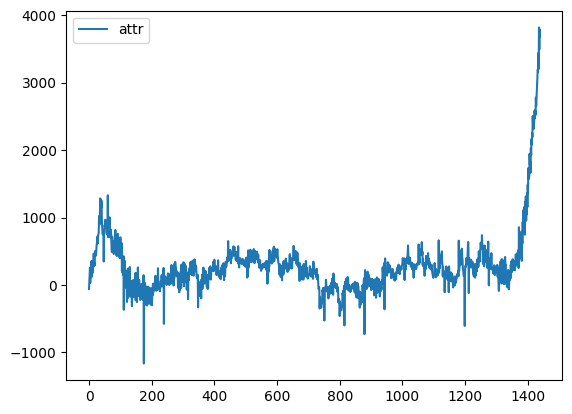

In [19]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,-0.739222
1,-0.525748
2,-0.378671
3,-0.076999
4,-0.539356
...,...
1435,6.287106
1436,7.608621
1437,6.906347
1438,7.553451


#### train_index구하기

In [21]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [22]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


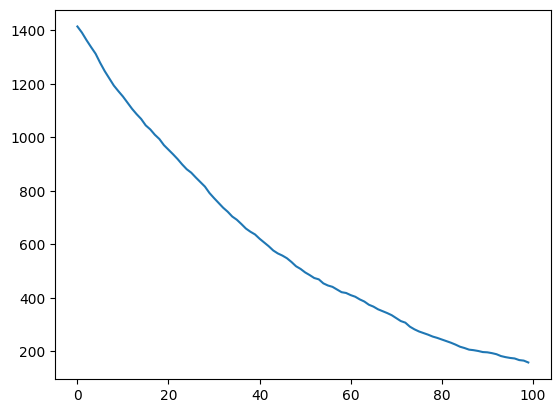

In [23]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [24]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 99460.,  90047.,  97806.,  ..., 109476., 107938., 110427.]],

        [[ 90047.,  97806.,  87141.,  ..., 107938., 110427., 112393.]],

        [[ 97806.,  87141.,  94147.,  ..., 110427., 112393., 107838.]],

        ...,

        [[ 74547.,  76519.,  69353.,  ...,  89959.,  83763., 150861.]],

        [[ 76519.,  69353.,  72669.,  ...,  83763., 150861.,  84639.]],

        [[ 69353.,  72669.,  67592.,  ..., 150861.,  84639.,  88357.]]],
       device='cuda:0') tensor([[[112393.]],

        [[107838.]],

        [[109474.]],

        [[106154.]],

        [[109562.]],

        [[104609.]],

        [[108481.]],

        [[104811.]],

        [[108068.]],

        [[101610.]],

        [[109562.]],

        [[102103.]],

        [[107085.]],

        [[101324.]],

        [[103611.]],

        [[ 97023.]],

        [[103033.]],

        [[ 97762.]],

        [[102938.]],

        [[ 95425.]],

        [[100112.]],

        [[ 92605.]],

        [[ 97253.]],

        [[ 92184.]

tensor([[[286167., 274788., 290124.,  ..., 324533., 334526., 323020.]],

        [[274788., 290124., 276905.,  ..., 334526., 323020., 334319.]],

        [[290124., 276905., 289307.,  ..., 323020., 334319., 322770.]],

        ...,

        [[279337., 309317., 294489.,  ..., 328607., 307861., 327998.]],

        [[309317., 294489., 305801.,  ..., 307861., 327998., 306404.]],

        [[294489., 305801., 293006.,  ..., 327998., 306404., 332097.]]],
       device='cuda:0') tensor([[[334319.]],

        [[322770.]],

        [[334129.]],

        [[319479.]],

        [[337478.]],

        [[319321.]],

        [[336048.]],

        [[317730.]],

        [[338208.]],

        [[315833.]],

        [[338251.]],

        [[318588.]],

        [[348310.]],

        [[318086.]],

        [[342301.]],

        [[330807.]],

        [[339323.]],

        [[329969.]],

        [[340325.]],

        [[323417.]],

        [[343630.]],

        [[319103.]],

        [[335722.]],

        [[318153.]

tensor([[[63774., 61322., 63821.,  ..., 58373., 62178., 58518.]],

        [[61322., 63821., 61686.,  ..., 62178., 58518., 61161.]],

        [[63821., 61686., 62971.,  ..., 58518., 61161., 59262.]],

        ...,

        [[54957., 57014., 55871.,  ..., 55214., 53404., 54764.]],

        [[57014., 55871., 56706.,  ..., 53404., 54764., 54089.]],

        [[55871., 56706., 55700.,  ..., 54764., 54089., 56305.]]],
       device='cuda:0') tensor([[[61161.]],

        [[59262.]],

        [[61486.]],

        [[58826.]],

        [[60567.]],

        [[58477.]],

        [[61364.]],

        [[57210.]],

        [[60423.]],

        [[56828.]],

        [[60887.]],

        [[56455.]],

        [[59688.]],

        [[55356.]],

        [[58256.]],

        [[56181.]],

        [[59957.]],

        [[56803.]],

        [[59975.]],

        [[56553.]],

        [[61486.]],

        [[57830.]],

        [[60816.]],

        [[56088.]],

        [[59625.]],

        [[55571.]],

        [[5946

tensor([[[309580., 290935., 308336.,  ..., 262378., 248214., 262175.]],

        [[290935., 308336., 289156.,  ..., 248214., 262175., 255224.]],

        [[308336., 289156., 309130.,  ..., 262175., 255224., 263036.]],

        ...,

        [[298846., 318117., 310537.,  ..., 260744., 241173., 259708.]],

        [[318117., 310537., 318222.,  ..., 241173., 259708., 245864.]],

        [[310537., 318222., 303039.,  ..., 259708., 245864., 259736.]]],
       device='cuda:0') tensor([[[255224.]],

        [[263036.]],

        [[258500.]],

        [[262741.]],

        [[255336.]],

        [[256979.]],

        [[252324.]],

        [[259191.]],

        [[254217.]],

        [[260109.]],

        [[256823.]],

        [[263297.]],

        [[256369.]],

        [[263677.]],

        [[258764.]],

        [[261943.]],

        [[256516.]],

        [[260613.]],

        [[255817.]],

        [[260235.]],

        [[264329.]],

        [[265801.]],

        [[268811.]],

        [[259350.]

       device='cuda:0') tensor([[[108673.]],

        [[100799.]],

        [[110516.]],

        [[102895.]],

        [[112541.]],

        [[105813.]],

        [[120851.]],

        [[113600.]],

        [[117409.]],

        [[111636.]],

        [[117519.]],

        [[112712.]],

        [[118625.]],

        [[113652.]],

        [[119870.]],

        [[112523.]],

        [[124116.]],

        [[116315.]],

        [[123868.]],

        [[118509.]],

        [[124946.]],

        [[117365.]],

        [[126615.]],

        [[120099.]],

        [[129580.]],

        [[121028.]],

        [[134417.]],

        [[125817.]],

        [[131842.]],

        [[123335.]],

        [[132446.]],

        [[126912.]],

        [[137531.]],

        [[127353.]],

        [[139233.]],

        [[128793.]],

        [[155469.]],

        [[137700.]],

        [[148524.]],

        [[135595.]],

        [[149224.]],

        [[139317.]],

        [[155266.]],

        [[146708.]],

        

       device='cuda:0') tensor([[[191123.]],

        [[185374.]],

        [[192598.]],

        [[182804.]],

        [[197361.]],

        [[190023.]],

        [[193911.]],

        [[183581.]],

        [[192072.]],

        [[177525.]],

        [[188528.]],

        [[175816.]],

        [[188534.]],

        [[176132.]],

        [[189181.]],

        [[172589.]],

        [[185613.]],

        [[171127.]],

        [[187433.]],

        [[174511.]],

        [[188277.]],

        [[174250.]],

        [[182282.]],

        [[176659.]],

        [[184894.]],

        [[181227.]],

        [[183654.]],

        [[176760.]],

        [[181787.]],

        [[171347.]],

        [[182147.]],

        [[170792.]],

        [[179542.]],

        [[168175.]],

        [[179606.]],

        [[166884.]],

        [[177476.]],

        [[164878.]],

        [[174682.]],

        [[163726.]],

        [[178520.]],

        [[165126.]],

        [[175463.]],

        [[166047.]],

        

In [25]:
val_x

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [26]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    result = criterion(pred,val_y).item()*100
    out_list.append(result)
    


0번째 모델 Training 완료 마지막 Epoch loss:38.762131677499625
1번째 모델 Training 완료 마지막 Epoch loss:30.997247532693418
2번째 모델 Training 완료 마지막 Epoch loss:40.923423198266676
3번째 모델 Training 완료 마지막 Epoch loss:45.37572861158636
4번째 모델 Training 완료 마지막 Epoch loss:38.1211696402032
5번째 모델 Training 완료 마지막 Epoch loss:34.990416588427045
6번째 모델 Training 완료 마지막 Epoch loss:37.12019151429365
7번째 모델 Training 완료 마지막 Epoch loss:26.075177486247476
8번째 모델 Training 완료 마지막 Epoch loss:30.960352718279033
9번째 모델 Training 완료 마지막 Epoch loss:35.57845556821961
10번째 모델 Training 완료 마지막 Epoch loss:32.793628084390654
11번째 모델 Training 완료 마지막 Epoch loss:42.06972162421109
12번째 모델 Training 완료 마지막 Epoch loss:37.00924922723169
13번째 모델 Training 완료 마지막 Epoch loss:37.58499631851074
14번째 모델 Training 완료 마지막 Epoch loss:27.185820262967308
15번째 모델 Training 완료 마지막 Epoch loss:29.774045799831317
16번째 모델 Training 완료 마지막 Epoch loss:23.508342035175385
17번째 모델 Training 완료 마지막 Epoch loss:34.43947050709431
18번째 모델 Training 완료 마지막 Epoch loss:29.215086718

In [27]:
val_y # 다음 예측 타겟값

tensor([[[ 97323.]],

        [[102155.]],

        [[ 96800.]],

        [[101213.]],

        [[ 93894.]],

        [[100698.]],

        [[ 94013.]],

        [[102999.]],

        [[ 95475.]],

        [[ 98919.]],

        [[ 93692.]],

        [[ 99729.]],

        [[ 93006.]],

        [[ 98725.]],

        [[ 90995.]],

        [[ 99042.]],

        [[ 91212.]],

        [[ 95602.]],

        [[ 89907.]],

        [[ 96044.]],

        [[ 92633.]],

        [[ 93161.]],

        [[ 91846.]],

        [[ 93309.]],

        [[ 89432.]],

        [[ 91668.]],

        [[ 87325.]],

        [[ 91681.]],

        [[ 88167.]],

        [[ 89379.]],

        [[ 88208.]]], device='cuda:0')

In [28]:
val_x # 예측 하는 값

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [29]:
result/68

0.06599233978811432

In [30]:
val_x.size()

torch.Size([31, 1, 1440])

In [31]:
model(X_test)

tensor([[[79068.2266]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [32]:
out_df = pd.DataFrame({"out":out_list})

<AxesSubplot: >

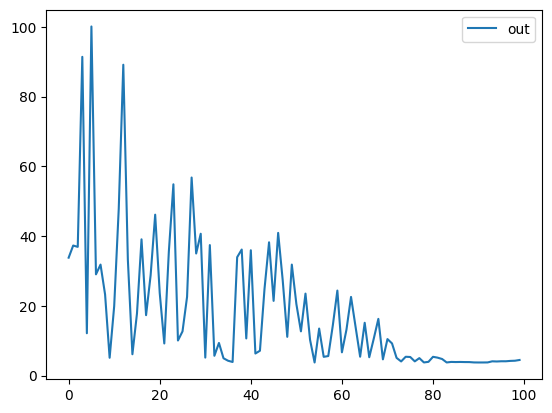

In [33]:
out_df.plot()

In [35]:
out_df.min()

out    3.772461
dtype: float64

## Result
* loss가 수렴함을 확인할 수 있다
* 1-prediction이라 너무 많은 인자가 필요 없다는 뜻이라고 생각이 된다.
* Q> 진동이 생기는 이유?
* Q2> 상승하는 시기?

In [34]:
attr_df.describe()

,attr
count,1.440000e+03
mean,-1.480297e-17
std,1.000347e+00
min,-3.117075e+00
25%,-4.703196e-01
50%,-1.096741e-01
75%,1.743387e-01
max,7.608621e+00
